## Spatial Sampling

### ROI (Region of Interest)
 * What is ROI
 * How to define a ROI
 * How ROI affects sampling and analysis

In [57]:
require("rgdal") # requires sp, will use proj.4 if installed
require("maptools")
require("ggplot2")
require("RColorBrewer")
require("raster")

In [58]:
# load in the shapefile
TZ_crop <- readOGR("TZ_crp_1k/", "TZ_crp_10k")

OGR data source with driver: ESRI Shapefile 
Source: "TZ_crp_1k/", layer: "TZ_crp_10k"
with 5 features
It has 1 fields


In [59]:
fx.ggplot<-function(data) {
    names(data@data) <- "id"
    data_points <- fortify(data, region="id")
    data_df <- join(data_points, data@data, by="id")
    names(data_df)[1:2] <- c("x", "y")
    ggplot(data_df) +aes(x,y)+
    geom_polygon(aes_string(group="group"))
}

In [60]:
p <- fx.ggplot(TZ_crop)
p

### Simple Random Sampling

In [61]:
set.seed(20160810)
random_sp <- spsample(TZ_crop, 100, "random")
random_sp_df <- as.data.frame(random_sp@coords)

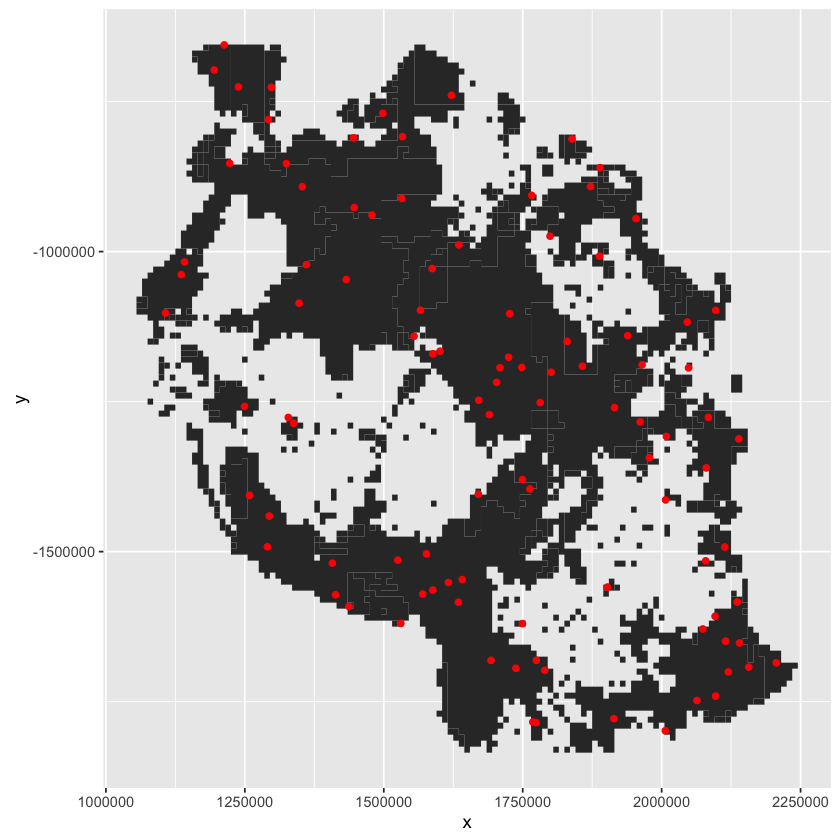

In [62]:
p+geom_point(data=random_sp_df, col="red")

### Simple Random Sampling
#### Advantage
. simple statistics analysis of data

#### Disadvantage 
. sampling variance is usually larger than other designs with equal costs: 
    
    (i) spatial coverage may be poor, 
    
    (ii) visiting sampling locations may be more time-consuming,

    (iii) estimating spatial correlations may be impossible due to large gaps.

### Stratified Sampling 
 * do a simple random sampling in each defined strata
![Multistage Image 1](img_sampling/multistage_sampling.jpg)


#### 1. Advantages
* higher efficiency than SRS,
    * lower travel cost
    * lower estimation variance

* guarantees separate estimates for given strata.

#### 2. Disadvantages
* with inappropriate stratification, may lose efficiency,
* higher complexity in survey design and analysis


#### 3. How to define a strata

* make strata that are as homogeneous in the response variable as possible, to maximize estimation efficiency.

In [63]:
fx.ggplot<-function(data,  scalefill="Predicted Treatment Response Strata") {
    names(data@data) <- "id"
    data_points <- fortify(data, region="id")
    data_df <- join(data_points, data@data, by="id")
    names(data_df)[1:2] <- c("x", "y")
    ggplot(data_df) +aes(x,y)+
    geom_polygon(aes_string(group="group", fill="id")) +
    scale_fill_brewer(scalefill)
}

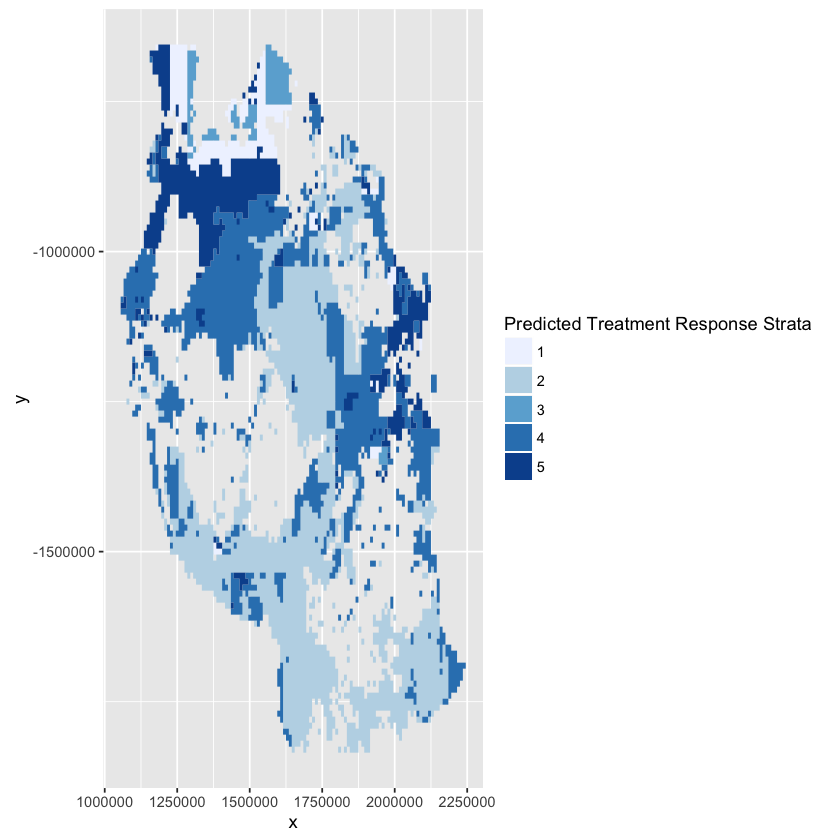

In [64]:
p <- fx.ggplot(TZ_crop)
p

#### 4. Incorporating stratified sampling into analysis
* Mean estimates: $$\bar{y} = \sum_{i=1}^{H} \frac{N_i}{N} \bar{y}_i$$
* Regression and predictions must include proxy variables that were used to design the strata

* Cross Validation uses stratified CV or block CV 

In [65]:
stratified_sp <- sapply(slot(TZ_crop, "polygons"), function(i){ spsample(i, n=20, type='random')})
stratified_sp_df <- as.data.frame(do.call("rbind",
                    sapply(stratified_sp, simplify = FALSE, function(i) i@coords)))

In [180]:
str(stratified_sp_df)

'data.frame':	50 obs. of  2 variables:
 $ x: num  1899910 1430348 1292212 2092039 1300560 ...
 $ y: num  -901709 -780771 -828083 -1155100 -659386 ...


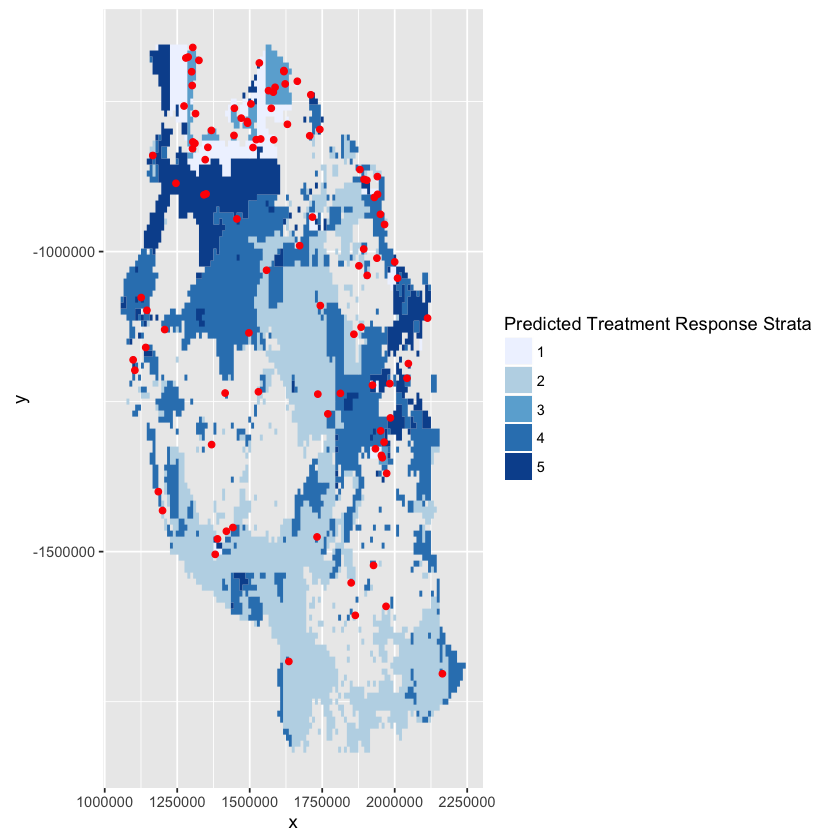

In [66]:
p+geom_point(data=stratified_sp_df, col="red")

#### Efficiency Gain

In [67]:
# generate simulated population 
s <- 10 # number of strata
sigma_v <- 0.1 
sigma_s <- rep(sigma_v, s) # standard deviation of each stratum
mean_s <- seq(1, 10) # mean of each stratum
mean_total <- mean(mean_s)
# population values
n_pop <- 1000
y_population <- sapply(1:s, function(i, mean_s, sigma_s) rnorm(n_pop, mean_s[i], sigma_s[i]), mean_s, sigma_s)

In [68]:
dim(y_population)

[1] 1000   10

In [69]:
n_s <- 10 # number of samples per stratum
n_sim <- 100

# simple random samples
y_mean_srs <- rep(NA, n_sim)
for(i in 1:n_sim){
    y_samples_srs <- sample(y_population, s*n_s)
    y_mean_srs[i] <- mean(y_samples_srs)
}

# stratified samples
y_mean_ss <- rep(NA, n_sim)
for(j in 1:n_sim){
    y_samples_ss <-  sapply(1:s, function(i) sample(y_population[, i], n_s))
    y_mean_ss[j] <- mean(y_samples_ss)
}

In [70]:
mean(y_mean_srs)

mean(y_mean_srs)

var(y_mean_srs)

var(y_mean_ss)

[1] 5.445775

[1] 5.445775

[1] 0.07626818

[1] 0.0001157484

### Cluster Random Sampling
* take a simple random sample among defined clusters
* do simple random samplings for each selected cluster

In [71]:
selected_clusters <- sample(1:length(slot(TZ_crop, 'polygons')), 3)
cluster_sp <- sapply(selected_clusters, function(i){spsample(slot(TZ_crop, 'polygons')[[i]], n=10, type='random')})
cluster_sp_df <- as.data.frame(do.call("rbind", sapply(stratified_sp, simplify = FALSE, function(i) i@coords)))

In [72]:
p+geom_point(data=cluster_sp_df, color="orange")

### Multistage Sampling
#### Sampling Within Grids
When we decide locations for grids, we can implement multistage sampling to select locations. Here we can use different settings of upper and lower values of the predicted control yields to sample points in different categories.

[sampling site](http://sampling.qed.ai/)


 #### One example
 ![Multistage Image 1](img_sampling/multistage_sampling.jpg)
 ![Multistage Image 2](img_sampling/Canvas 2.png)
 

In [73]:
require(lattice)
require(proj4)
require(sampling)

In [74]:
DGG <- CRS("+proj=utm +zone=37 +datum=WGS84 +units=m +no_defs")

lowerlocationsx <- c(38)
lowerlocationsy <- c(8)

# xoff & yoff specify lower left (starting) position in the appropriate DGG coordinates
xycenter.location <- project(matrix(c(lowerlocationsx, lowerlocationsy), 1, 2), DGG)
xoff <-  xycenter.location[1]-5000
yoff <- xycenter.location[2]-5000

xdim <- 100
ydim <- 100

# specify grid resolution (grain, in m)
grain <- 100

# generate the grid
grid <- as.data.frame(coordinates(GridTopology(c(xoff,yoff), c(grain,grain), c(xdim,ydim))))
colnames(grid) <- c("x", "y")

res.pixel <- c(5000, 1000, grain) 
X2 <- ceiling((grid$x-xoff+1/2*xdim)/res.pixel[1])
Y2 <- ceiling((grid$y-yoff+1/2*ydim)/res.pixel[1])
L2 <- cleanstrata(paste(X2, Y2, sep=""))

X1 <- ceiling((X2*res.pixel[1]-(grid$x-xoff))/res.pixel[2])
Y1 <- ceiling((Y2*res.pixel[1]-(grid$y-yoff))/res.pixel[2])
L1 <- cleanstrata(paste(X1, Y1, sep="")) 

X0 <- ceiling((X1*res.pixel[2]+(grid$x-xoff-X2*res.pixel[1]))/res.pixel[3])
Y0 <- ceiling((Y1*res.pixel[2]+(grid$y-yoff-Y2*res.pixel[1]))/res.pixel[3])
L0 <- cleanstrata(paste(X0, Y0, sep=""))


grid <- cbind(grid, L2, L1, L0)
str(grid)

'data.frame':	10000 obs. of  5 variables:
 $ x : num  384795 384895 384995 385095 385195 ...
 $ y : num  889332 889332 889332 889332 889332 ...
 $ L2: int  2 2 2 2 2 2 2 2 2 2 ...
 $ L1: int  21 21 21 21 21 21 21 21 21 21 ...
 $ L0: int  10 20 30 40 50 60 70 80 90 100 ...


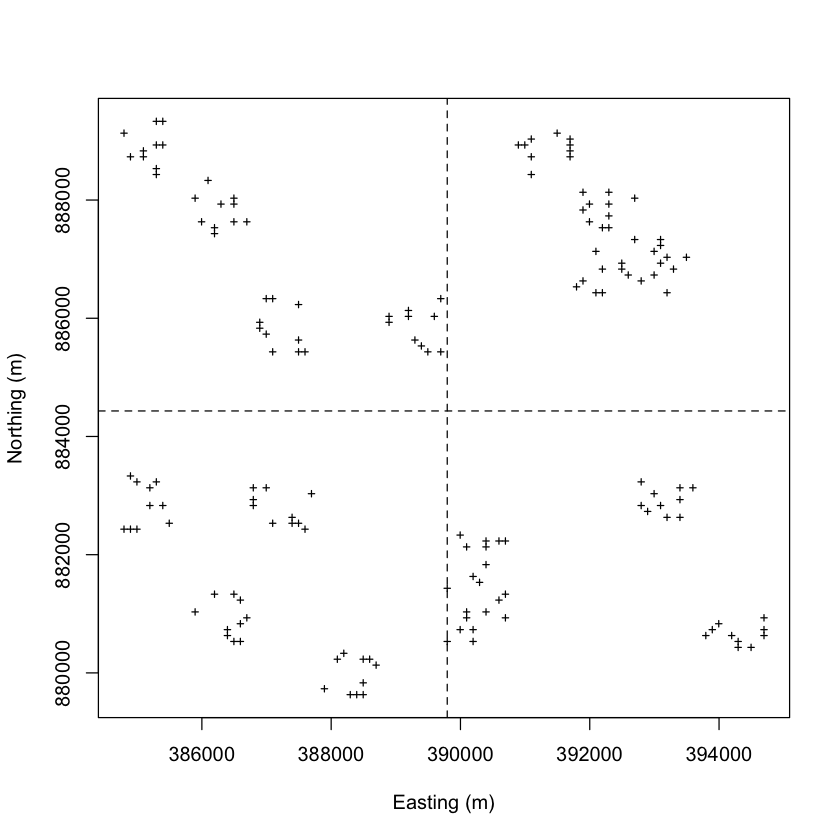

In [75]:
# draw a sample
# s.size specifies the sample size at each level (e.g. L2:4, L1:4, L0:10)
s.size <- list(rep(2500, 4), rep(4, 4), rep(10, 16))

s <- mstage(grid, stage=list("stratified", "cluster", ""), varnames=list("L2","L1","L0"), size=s.size, method=list("srswor", "srswor", "srswor"), description=FALSE)

sample.DGG <- getdata(grid, s[[3]])
plot(y~x, data=sample.DGG, xlab="Easting (m)", ylab="Northing (m)", pch=3, cex=0.5)

abline( h=xycenter.location[2],  lty=2)
abline( v=xycenter.location[1],  lty=2)

# define a spatial point data object & project from DGG to geographic coordinates 
coordinates(sample.DGG) <- ~x+y
proj4string(sample.DGG) <- DGG
sample.LL <- spTransform(sample.DGG, CRS("+proj=longlat +datum=WGS84"))
write.csv(as.data.frame(sample.LL), paste("E", lowerlocationsx,"N", lowerlocationsy, "_160pts", ".csv", sep=""))